In [77]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
import copy

import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pypfopt.plotting import plot_efficient_frontier, plot_weights
import utils as ut

## Global Settings

In [2]:
seed = 1227
rs = np.random.RandomState(seed)

mpl.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')

## In Sample Data

In [3]:
in_sample_returns = pd.read_csv('../data/in_sample_returns.csv', index_col=0)
in_sample_returns.head()

,2021-10-28
AAPL,0.521375
AEP,0.060583
AMT,0.261443
AMZN,0.276456
BA,0.039633


In [4]:
in_sample_cov = pd.read_csv('../data/in_sample_cov.csv', index_col=0)
in_sample_cov.head(5)

,AAPL,AEP,AMT,AMZN,BA,CVX,DD,DIS,GE,GOOGL,...,SHW,SLG,SPY,TGT,TSN,UNH,VZ,WFC,WMT,XOM
AAPL,0.095714,0.021830,0.038438,0.056956,0.054316,0.035026,0.036938,0.033291,0.033291,0.054275,...,0.038213,0.032912,0.044638,0.030750,0.017275,0.039239,0.014611,0.034887,0.026007,0.028608
AEP,0.021830,0.051296,0.033070,0.010411,0.031952,0.019889,0.022170,0.019649,0.023557,0.017293,...,0.022812,0.036622,0.020981,0.018177,0.013622,0.026930,0.020990,0.029149,0.016900,0.018192
AMT,0.038438,0.033070,0.070126,0.026953,0.032994,0.025128,0.022267,0.020084,0.019616,0.030334,...,0.033017,0.038047,0.030120,0.023168,0.015685,0.035387,0.018030,0.026352,0.021104,0.015527
AMZN,0.056956,0.010411,0.026953,0.080966,0.027594,0.013394,0.015042,0.022969,0.009557,0.048888,...,0.023014,0.009056,0.031192,0.022405,0.008059,0.023792,0.008183,0.013129,0.017111,0.012619
BA,0.054316,0.031952,0.032994,0.027594,0.252050,0.111366,0.090736,0.084193,0.131598,0.052987,...,0.040727,0.145293,0.058776,0.030534,0.065756,0.051050,0.024373,0.118297,0.016748,0.104827


## Optimization Model

There are essentially two things we need to specify: 

* the optimization objective
* the optimization constraints

From an implementation standpoint, the actual optimization occurs in the `efficient_frontier.EfficientFrontier` class of the `pypfopt` package. This class, which inherits from a `BaseConvexOptimizer` class, contains the encapsulated public methods that optimize different objectives given different constraints. To use the methods, we first instantiate an instance of the class:

In [35]:
markowitz_model = EfficientFrontier(
    expected_returns=in_sample_returns.to_numpy().flatten(),
    cov_matrix=in_sample_cov,
    weight_bounds=(0, 1), # Assume fully invested portfolio
    solver=None # Use cvxpy’s default choice of solver
)

### Efficient Frontier

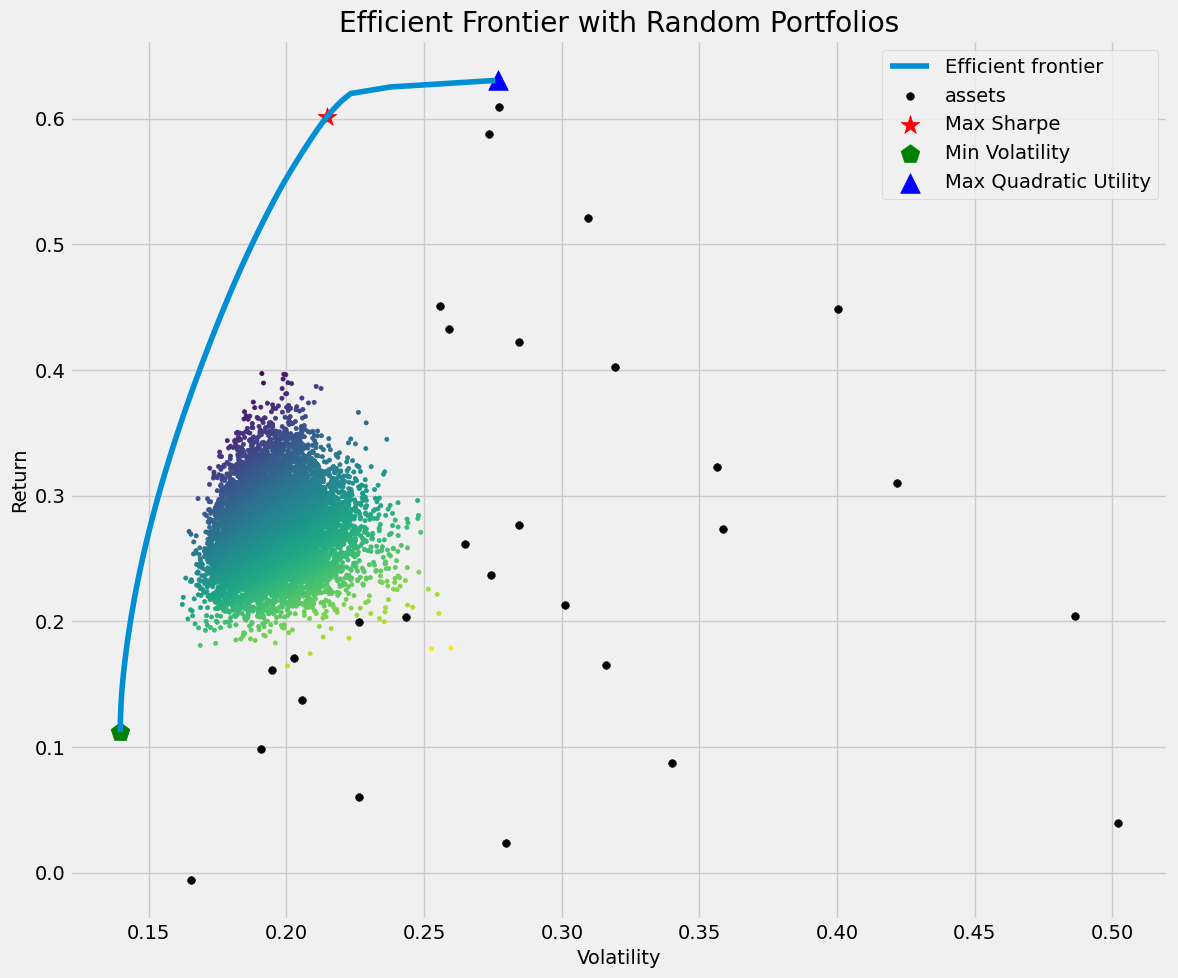

In [37]:
ut.custom_efficient_frontier(markowitz_model, show_assets=True, figsize=(12, 10));

## Maximal Sharpe Ratio Portfolio

We begin with the maximal sharpe ratio portfolio. Sharpe Ratio, which is a measure of calculating risk adjusted return, defines the average return earned in excess of the risk free rate per unit of volatility or total risk in an investment asset or a trade strategy. The Sharpe Ratio is defined as:

$$
\frac{\left(r_x-R_f\right)}{\sigma}
$$

where
- $r_x$ is the average rate of return on an investment $x$
- $R_f$ is the best available rate of return of a risk free security
- $\sigma$ the standard deviation of $r_x$

The higher the Sharpe Ratio value, the more excess returns can be expected for the extra volatility that they are exposed to by holding a risky asset. Again a Sharpe Ratio of 0 obviously indicates a risk free asset or a portfolio with no excess return, zero risk premium. A portfolio optimization problem that serves to include Sharpe Ratio, has its objective of maximizing Sharpe Ratio as follows:

$$
\operatorname{Max}\left(\frac{\left(r_x-R_f\right)}{\sigma}\right)
$$

For the risk free rate, we will use the current 3 month treasury bill rate--- $4.74\%$. In addition, mean-variance optimization often results in many weights being negligible, i.e the efficient portfolio does not end up including most of the assets. This is expected behavior, but it may be undesirable if we need a certain number of assets in our portfolio.

In order to coerce the mean-variance optimizer to produce more non-negligible weights, we add what can be thought of as a "small weights penalty" to all of the objective functions, parameterized by $\gamma$. Considering the minimum variance objective for instance:

$$
\underset{w}{\operatorname{minimise}}\left\{w^T \Sigma w\right\} \quad \longrightarrow \underset{w}{\operatorname{minimise}}\left\{w^T \Sigma w+\gamma w^T w\right\}
$$

Note that $w^T w$ is the same as the sum of squared weights. This term reduces the number of negligible weights, because it has a minimum value when all weights are equally distributed, and maximum value in the limit where the entire portfolio is allocated to one asset. The author of the package calls this the L2 regularization because it has exactly the same form as the L2 regularization term in machine learning, though a slightly different purpose (in $\mathrm{ML}$ it is used to keep weights small while here it is used to make them larger).

In [74]:
max_sharpe_model = copy.deepcopy(markowitz_model)
# Add l2 regularization
max_sharpe_model.add_objective(objective_functions.L2_reg, gamma=2)
max_sharpe_result = max_sharpe_model.max_sharpe(risk_free_rate=0.0474)

### Post Processing

After optimal weights have been generated, it is often necessary to do some post-processing before they can be used practically. In particular, we can use portfolio optimization techniques to generate a portfolio allocation – a list of tickers and corresponding integer quantities that we could go and purchase at a broker.

However, it is not trivial to convert the continuous weights (output by any of our optimization methods) into an actionable allocation. For example, let us say that we have $10,000 that we would like to allocate. If we multiply the weights by this total portfolio value, the result will be dollar amounts of each asset. So if the optimal weight for Apple is 0.15, we need $1500 worth of Apple stock. However, Apple shares come in discrete units (e.g., $190), so we will not be able to buy exactly $1500 of stock. The best we can do is to buy the number of shares that gets us closest to the desired dollar value.

We can do this using integer programming. In effect, the integer programming approach searches the space of possible allocations to find the one that is closest to our desired weights. We will use the following notation:

- $T \in \mathbb{R}$ is the total dollar value to be allocated
- $p \in \mathbb{R}^n$ is the array of latest stock prices
- $w \in \mathbb{R}^n$ is the set of target weights
- $x \in \mathbb{Z}^n$ is the integer allocation decision variables (i.e the result)
- $r \in \mathbb{R}$ is the remaining unallocated dollar amount, i.e $r=T-x \cdot p$
  
The optimization problem is then given by:

$$
\begin{array}{ll}
\underset{x \in \mathbb{Z}^n}{\operatorname{minimise}} & r+\|w T-x \odot p\|_1 \\
\text { subject to } & r+x \cdot p=T
\end{array}
$$



In [86]:
# Create a random vector of prices (we may change the stocks later and so we will look up the prices then)
lastest_prices = pd.Series(np.random.uniform(50, 200, size=30).round(4), index=in_sample_returns.index)
lastest_prices.head(5)


AAPL    160.6432
AEP      85.5778
AMT     142.6813
AMZN     84.7144
BA      174.6366
dtype: float64

In [92]:
# Instantiate a instance of DiscreteAllocation
da = DiscreteAllocation(
    weights=max_sharpe_result,
    latest_prices=lastest_prices,
    total_portfolio_value=62556
)

In [95]:
# Solve integer programming problem
allocations = da.lp_portfolio(reinvest=False)
allocations

({'AEP': 2,
  'AMT': 14,
  'AMZN': 27,
  'BA': 1,
  'CVX': 12,
  'DD': 4,
  'DIS': 4,
  'GE': 17,
  'GOOGL': 89,
  'HD': 61,
  'IBM': 2,
  'JNJ': 4,
  'JPM': 21,
  'KO': 4,
  'MCD': 7,
  'MSFT': 47,
  'PFE': 9,
  'PG': 7,
  'SBUX': 12,
  'SHW': 23,
  'SLG': 5,
  'SPY': 23,
  'TGT': 70,
  'TSN': 9,
  'UNH': 23,
  'VZ': 4,
  'WFC': 44,
  'WMT': 6,
  'XOM': 13},
 1033.2093903671266)

We can compute the RSME error between the discretized weights and continuous weights.

In [97]:
da._allocation_rmse_error()

AAPL: allocated 0.000, desired 0.078
AEP: allocated 0.003, desired 0.000
AMT: allocated 0.032, desired 0.030
AMZN: allocated 0.037, desired 0.033
BA: allocated 0.003, desired 0.000
CVX: allocated 0.026, desired 0.024
DD: allocated 0.004, desired 0.000
DIS: allocated 0.008, desired 0.006
GE: allocated 0.035, desired 0.032
GOOGL: allocated 0.104, desired 0.099
HD: allocated 0.066, desired 0.062
IBM: allocated 0.003, desired 0.000
JNJ: allocated 0.004, desired 0.000
JPM: allocated 0.055, desired 0.052
KO: allocated 0.008, desired 0.006
MCD: allocated 0.019, desired 0.017
MSFT: allocated 0.097, desired 0.094
PFE: allocated 0.023, desired 0.021
PG: allocated 0.016, desired 0.013
SBUX: allocated 0.024, desired 0.021
SHW: allocated 0.070, desired 0.068
SLG: allocated 0.010, desired 0.008
SPY: allocated 0.037, desired 0.033
TGT: allocated 0.112, desired 0.108
TSN: allocated 0.024, desired 0.021
UNH: allocated 0.062, desired 0.060
VZ: allocated 0.004, desired 0.000
WFC: allocated 0.062, desired

0.014598518353141379